# *Modeling Part: Random Forest*

****************************************************************************************************************************************

In [4]:
import pandas as pd
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score


dl.dropboxusercontent.com

In [5]:
url_final = 'https://dl.dropboxusercontent.com/scl/fi/vhc8mgzyrhpaprncrlql5/final_all_defects.csv?rlkey=c0mqe7erfhss29s7wwf3aac3c&dl=1'
df_final = pd.read_csv(url_final)

In [6]:
df_final.shape

(299384, 51)

In [7]:
df_final.head()

,COIL,DATE,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,PYRO_2_FRST_3_ZONE,LASER_FRN_1,LASER_FRN_2,LASER_FRN_8,LASER_FRN_9,...,FILL_BENDING_POS,FILL_BENDING_NEG,MT_ADJUSTED,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6,Has_Defect
0,240627,2019-03-15,14:25:23.060,-1.698350,-6.480611,-6.260562,-1.108191,-2.389473,-3.811867,-2.455160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,240627,2019-03-15,14:25:53.060,-1.712668,-6.518866,-6.253058,-1.108199,-2.376155,-3.795318,-2.455455,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,240627,2019-03-15,14:26:23.060,-2.213529,-6.513475,-6.261373,-1.108177,-2.369908,-3.783512,-2.455522,...,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,240627,2019-03-15,14:27:08.060,-2.212934,-6.484467,-6.161300,-1.108188,-2.340920,-3.760286,-2.455393,...,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,240627,2019-03-15,14:27:38.060,-1.811965,-6.445186,-5.887232,-1.108134,-2.305111,-3.712663,-2.454928,...,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**'df_final'** is now our final dataframe with the selected features and the target column of interest ('Has_Defect') at the end

#### Splitting our data into Train, Validation and Test sets

To ensure that the same coils are not split across both the training and testing sets, thereby preventing data leakage, we need to stratify the split based on the coil ID. This means we should split our dataset in such a way that all records belonging to a specific coil are either entirely in the training set or entirely in the testing set

In [8]:
# Get unique coil IDs and split them
unique_coils = df_final['COIL'].unique()
train_coils, test_coils = train_test_split(unique_coils, test_size=0.2, random_state=42)
train_coils, val_coils = train_test_split(train_coils, test_size=0.25, random_state=42)  # Splitting the remaining 80% into 60% train and 20% validation

# Split the DataFrame into training, validation, and testing sets based on coil IDs
train_df = df_final[df_final['COIL'].isin(train_coils)]
val_df = df_final[df_final['COIL'].isin(val_coils)]
test_df = df_final[df_final['COIL'].isin(test_coils)]


In [9]:
target = "Has_Defect"

# Prepare the data
X_train = train_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', 'DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6', target], axis=1)  
y_train = train_df[target]    

X_val = val_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS','DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6', target], axis=1)
y_val = val_df[target]

X_test = test_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', 'DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6', target], axis=1)   
y_test = test_df[target]     

### Random Forest 

Optimized Hyperparameter Tuning for Random Forest Classifier with Reduced Computational Complexity

In [10]:
# Initialize the classifier
rf_clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100],  # Keeping one option to reduce combinations
    'max_depth': [10, None],  # A reasonable depth, and None for fully grown trees
    'min_samples_split': [2],  # Default value
    'min_samples_leaf': [1],  # Default value
    'bootstrap': [True]  # Keeping bootstrapping enabled
}

# parameters = {
#     'n_estimators': [100, 200, 300],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],  # Maximum number of levels in each decision tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of data points placed in a node before the node is split
#     'min_samples_leaf': [1, 2, 4]     # Minimum number of data points allowed in a leaf node
# }

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, 
                           scoring='recall', cv=3, n_jobs=1, verbose=2)

# Assuming X_train and y_train are your training features and labels
grid_search.fit(X_train, y_train)

# Get the best parameters and use them to create the best model
best_params = grid_search.best_params_
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Fit the best model
best_rf.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min


RandomForestClassifier(max_depth=10, random_state=42)

Validation Accuracy: 0.7930817297333135
Testing Accuracy: 0.7901385892658691

**Classification report for Random Forest Classifier on the test set:**

              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84     38134
         1.0       0.74      0.68      0.71     23054

    accuracy                           0.79     61188
   macro avg       0.78      0.77      0.77     61188
weighted avg       0.79      0.79      0.79     61188



Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier on the test set')

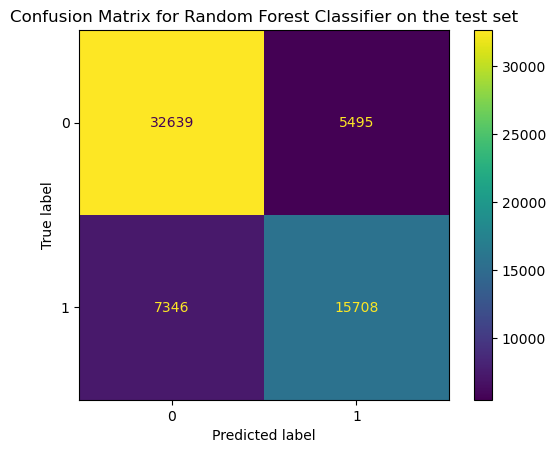

In [11]:
# Predict on the validation set
y_val_pred = best_rf.predict(X_val)
# Calculate the accuracy of the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

# Predict on the test set
y_test_pred = best_rf.predict(X_test)
# Calculate the accuracy of the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy}\n")

# Print out the classification report which provides a summary of the model's performance
print("**Classification report for Random Forest Classifier on the test set:**\n")
print(classification_report(y_test, y_test_pred))

# Create a confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for Random Forest Classifier on the test set')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


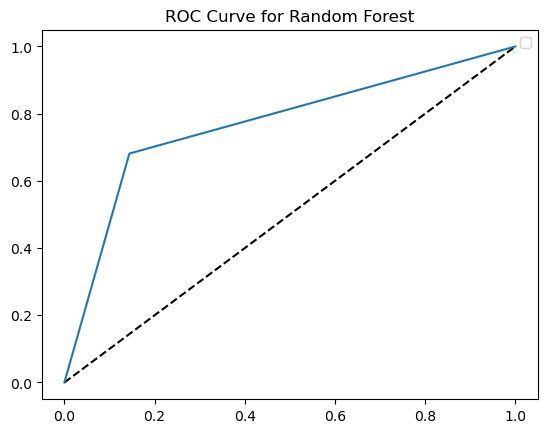

In [12]:
# Plot the ROC curve for Random Forest
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_test_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf)
plt.title('ROC Curve for Random Forest')
plt.legend()
plt.show()

In [13]:
# Feature importances for the Random Forest model
feature_importances_rf = best_rf.feature_importances_

# Summary of feature importance
summary_imp = pd.DataFrame(list(zip(X_train.columns, feature_importances_rf)), columns=["Feature", "Importance"])
summary_imp = pd.DataFrame(summary_imp.sort_values(by="Importance", ascending=False))
print("Summary of feature importance:")
print(summary_imp)


Summary of feature importance:
                 Feature  Importance
1                TEMP_Z1    0.133837
2     PYRO_2_FRST_3_ZONE    0.082570
14              AIR_Z2_1    0.062180
21          LASER_RAFF_9    0.052823
36             FILL_TIRO    0.052434
0          SPEED_PROCESS    0.050466
16            TIRO_FORNO    0.039965
13              AIR_Z1_1    0.038356
20                 EXT_1    0.035539
3            LASER_FRN_1    0.032355
26              ELET_FE2    0.032022
28             DEC_H2SO4    0.028009
37              FILL_ALL    0.028006
25            ELET_H2SO4    0.025556
33           SPZ1_R1_ASS    0.023127
8              AIR_CH4_2    0.022566
29               DEC_FE2    0.021710
9              AIR_CH4_3    0.021040
30               DEC_FE3    0.019951
5            LASER_FRN_8    0.019813
4            LASER_FRN_2    0.019227
15  FRN_FURNACE_PRESSURE    0.017694
6            LASER_FRN_9    0.016764
35            FILL_FORZA    0.012767
39      FILL_BENDING_NEG    0.011657
10     

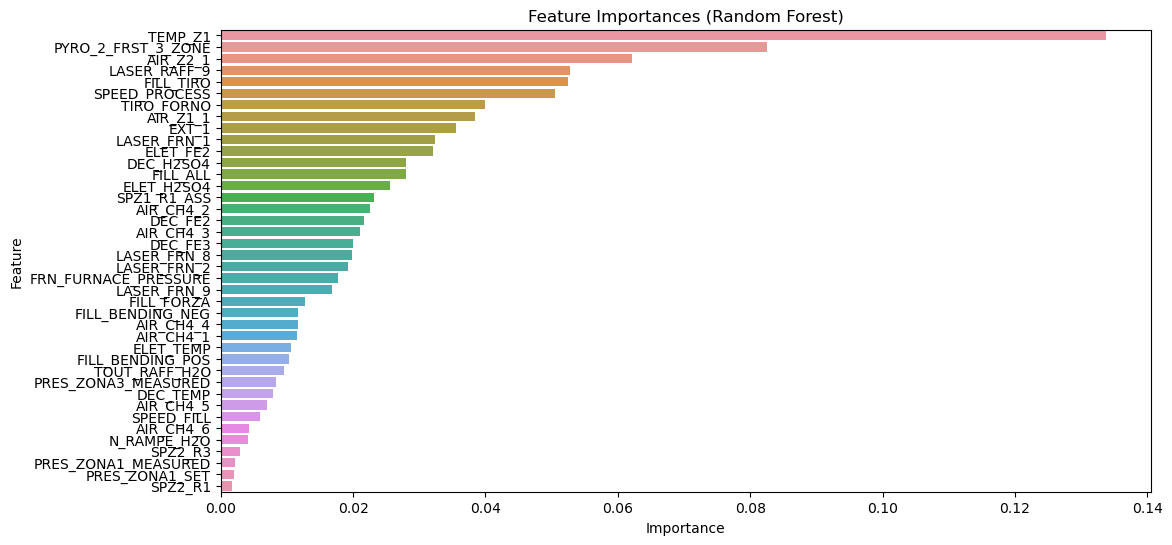

In [14]:
# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=summary_imp["Importance"], y=summary_imp["Feature"])
plt.title("Feature Importances (Random Forest)")
plt.show()

In [15]:
X_new = df_final.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', 'DIF_TIPO_1',\
                                  'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6', target], axis=1) 


In [16]:
# Create predictions for our dataset
defect_predictions = best_rf.predict(X_new) 


In [17]:
# Add prediction to 'df_final' dataset
df_final['Defect_Predictions'] = defect_predictions


In [19]:
# Add a column for misclassified instances if the predicted label is different from actual label 
df_final['Misclassified'] = df_final['Has_Defect'] != df_final['Defect_Predictions']

In [52]:
# Check how many misclassifications are there?
misclassified_count = df_final['Misclassified'].sum()
print("Number of Misclassified Instances:", misclassified_count)

# Create a df subset for only misclassified instances
misclassified_defects = df_final[df_final['Misclassified'] == True][['Has_Defect', 'Defect_Predictions','DIF_TIPO_1',\
                                  'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']]
misclassified_defects.head()

Number of Misclassified Instances: 30612


,Has_Defect,Defect_Predictions,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
4226,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4227,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4231,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4232,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4233,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
#Subdivide this new dataframe into two dataframes: one for the actual defects and one for the non-defects
false_negative = misclassified_defects[misclassified_defects['Defect_Predictions'] == 0]
false_positive = misclassified_defects[misclassified_defects['Defect_Predictions'] == 1]

# Print out some information about each dataframe
print("Number of False Negatives:", false_negative.shape[0])
print("Number of False Positives:", false_positive.shape[0])


Number of False Negatives: 16195
Number of False Positives: 14417


In [66]:
false_positive[['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']].value_counts()

DIF_TIPO_1  DIF_TIPO_2  DIF_TIPO_3  DIF_TIPO_4  DIF_TIPO_5  DIF_TIPO_6
0.0         0.0         0.0         0.0         0.0         0.0           14417
Name: count, dtype: int64

### False Negatives

In [61]:
# Number of defects of type 1 in the false negatives
fn_type1 = false_negative['DIF_TIPO_1'].sum()
fn_type2 = false_negative['DIF_TIPO_2'].sum()
fn_type3 = false_negative['DIF_TIPO_3'].sum()
fn_type4 = false_negative['DIF_TIPO_4'].sum()
fn_type5 = false_negative['DIF_TIPO_5'].sum()
fn_type6 = false_negative['DIF_TIPO_6'].sum()
print(fn_type1, fn_type2, fn_type3, fn_type4, fn_type5, fn_type6)


1363.0 2034.0 11942.0 7134.0 1302.0 639.0


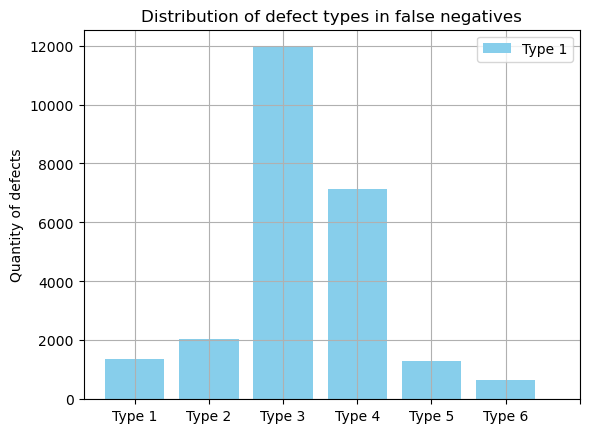

In [62]:
plt.bar(['Type 1', 'Type 2', 'Type 3', 'Type 4', 'Type 5', 'Type 6'], \
        [fn_type1, fn_type2, fn_type3, fn_type4, fn_type5, fn_type6], color = 'skyblue')
plt.xticks([x for x in range(0, 7)])
plt.ylabel('Quantity of defects')
plt.title('Distribution of defect types in false negatives')
plt.legend(['Type 1', 'Type 2', 'Type 3', 'Type 4', 'Type 5', 'Type 6'])
plt.grid(True)
plt.show()